C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8232\1813339587.py:207: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = compare_df.groupby(['Strategy', 'Group']).agg(



 Cycle Time Summary by Strategy and Group:
  Strategy Group  Count     MeanCycle  MedianCycle  MaxLateness  OnTimePct
0     BASE   PHL      3  29269.980000    29150.758     -179.858      100.0
4     FIFO   PHL      3  38186.578000    38201.748     9041.748        0.0
1     BASE   PRL      2  28635.531000    28635.531   -37100.604      100.0
5     FIFO   PRL      2  34180.383000    34180.383   -34686.436      100.0
2     BASE   ERL     28  28276.850714    28203.858   -40096.752      100.0
6     FIFO   ERL     28  29301.291214    28759.386   -35771.854      100.0
3     BASE   EHL     26  28291.923538    28203.858    -1210.610      100.0
7     FIFO   EHL     26  29623.261846    28923.072     2771.334       65.4


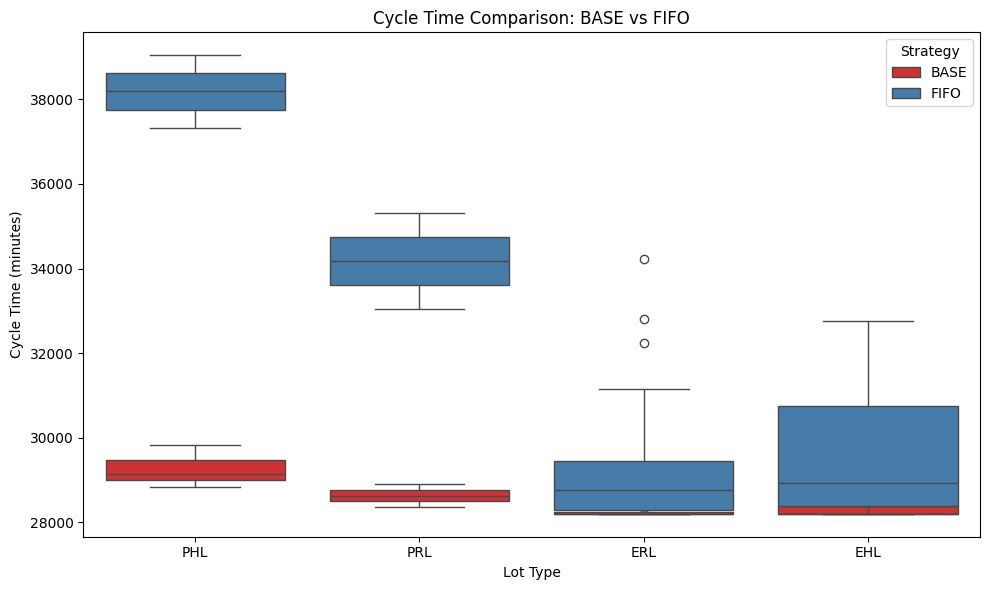

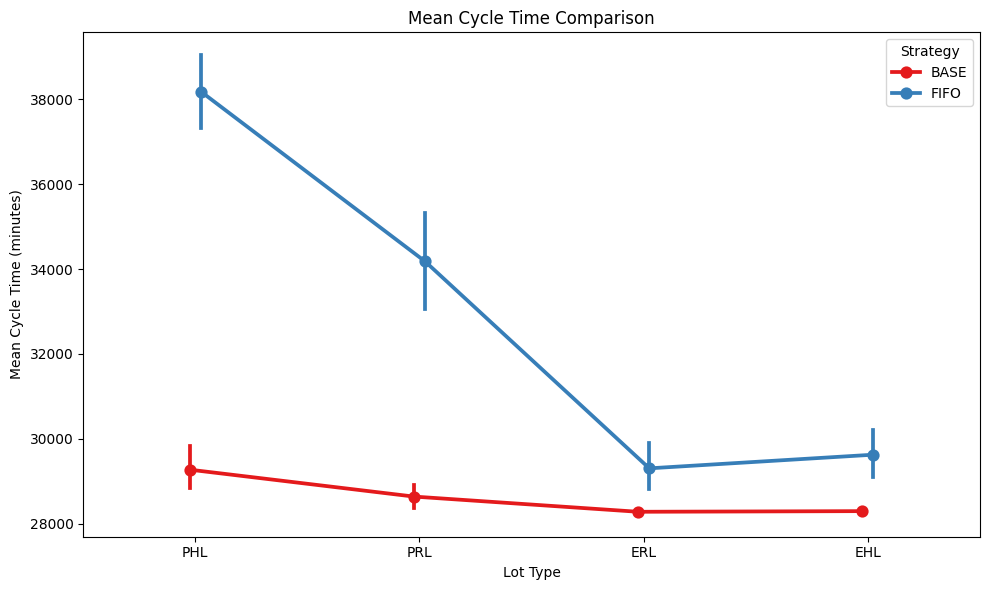

In [2]:
import simpy
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
file_path = "SMT_2020_Model_Data_-_HVLM_E.xlsx"
lot_df = pd.read_excel(file_path, sheet_name="Lotrelease")
lot_df_eng = pd.read_excel(file_path, sheet_name="Lotrelease Engineering")
route_df = pd.read_excel(file_path, sheet_name='Route_Product_3')

# Concatenate and process lot data
lot_df = pd.concat([lot_df, lot_df_eng], ignore_index=True)
lot_df['START DATE'] = pd.to_datetime(lot_df['START DATE'])
lot_df['DUE DATE'] = pd.to_datetime(lot_df['DUE DATE'])
base_time = lot_df['START DATE'].min()
lot_df['ReleaseTimeMin'] = (lot_df['START DATE'] - base_time).dt.total_seconds() / 60
lot_df['DueTimeMin'] = (lot_df['DUE DATE'] - base_time).dt.total_seconds() / 60

# Process steps data
steps = route_df[['STEP', 'TOOLGROUP', 'MEAN']].dropna()
steps['MEAN'] = pd.to_numeric(steps['MEAN'], errors='coerce')

SIM_TIME = 1100000

def classify_lot_type(lot_id):
    """Improved lot type classification based on SMT2020 naming conventions"""
    if pd.isna(lot_id):
        return "Unknown"
    
    lot_str = str(lot_id).upper()
    
    # Engineering lots
    if "ENG" in lot_str:
        if "HL" in lot_str or "HOT" in lot_str:
            return "EHL"  # Engineering Hot Lot
        else:
            return "ERL"  # Engineering Regular Lot
    
    # Production lots
    elif "HL" in lot_str or "HOT" in lot_str:
        return "PHL"  # Production Hot Lot
    else:
        return "PRL"  # Production Regular Lot (default)

def balanced_sample(df, n_each=40):
    sampled = []
    for t in ['PRL', 'PHL', 'ERL', 'EHL']:
        subset = df[df['LOT NAME/TYPE'].apply(classify_lot_type) == t]
        if not subset.empty:
            sampled.append(subset.sample(n=min(n_each, len(subset)), random_state=42))
    return pd.concat(sampled)

# Apply balanced sampling and classification
lot_df = balanced_sample(lot_df, n_each=100)
lot_df['LotType'] = lot_df['LOT NAME/TYPE'].apply(classify_lot_type)

lot_df.loc[lot_df['LotType'].isin(['PHL', 'EHL']), 'DueTimeMin'] = lot_df['ReleaseTimeMin'] + 30000
lot_df.loc[lot_df['LotType'].isin(['PRL', 'ERL']), 'DueTimeMin'] = lot_df['ReleaseTimeMin'] + 70000

def base_dispatch_priority(lot_type):
    priorities = {
        'EHL': 100,
        'PHL': 90,
        'ERL': 40,
        'PRL': 10
    }
    return priorities.get(lot_type, 0)

def run_base_dispatch_sim():
    env = simpy.Environment()
    tool_resources = {
        tool: simpy.PriorityResource(env, capacity=2)
        for tool in steps['TOOLGROUP'].unique()
    }
    lot_records = {}
    lot_type_counts = {'PRL': 0, 'PHL': 0, 'ERL': 0, 'EHL': 0, 'Unknown': 0}
    completed_type_counts = {'PRL': 0, 'PHL': 0, 'ERL': 0, 'EHL': 0, 'Unknown': 0}

    def process_lot(env, lot_id, release, due, lot_type):
        yield env.timeout(max(0, release - env.now))
        lot_records[lot_id] = {'start': env.now, 'due': due, 'type': lot_type}

        for idx, row in steps.iterrows():
            tool = row['TOOLGROUP']
            proc_time = row['MEAN']
            base_prio = base_dispatch_priority(lot_type)
            priority = base_prio  # Using only base_prio as specified in the original code

            with tool_resources[tool].request(priority=priority) as req:
                yield req
                yield env.timeout(proc_time)

        lot_records[lot_id]['end'] = env.now
        completed_type_counts[lot_type] += 1

    def lot_release_process(env):
        for _, row in lot_df.iterrows():
            lot_id = row['LOT NAME/TYPE']
            release = row['ReleaseTimeMin']
            due = row['DueTimeMin']
            lot_type = classify_lot_type(lot_id)
            
            delay_map = {'PRL': 4000, 'ERL': 1000, 'PHL': 0, 'EHL': 0}
            release += delay_map.get(lot_type, 0)

            if lot_type not in lot_type_counts:
                lot_type_counts['Unknown'] += 1
            else:
                lot_type_counts[lot_type] += 1

            env.process(process_lot(env, lot_id, release, due, lot_type))
            yield env.timeout(0)

    env.process(lot_release_process(env))
    env.run(until=SIM_TIME)

    rows = []
    for lot_id, rec in lot_records.items():
        if 'end' in rec:
            rows.append({
                'Lot': lot_id,
                'Type': rec['type'],
                'Start': rec['start'],
                'End': rec['end'],
                'Due': rec['due'],
                'CycleTime': rec['end'] - rec['start'],
                'Lateness': rec['end'] - rec['due'],
                'OnTime': rec['end'] <= rec['due']
            })
    return pd.DataFrame(rows)

def run_fifo_dispatch_sim():
    env = simpy.Environment()
    tool_resources = {
        tool: simpy.Resource(env, capacity=1)
        for tool in steps['TOOLGROUP'].unique()
    }
    lot_records = {}
    lot_type_counts = {'PRL': 0, 'PHL': 0, 'ERL': 0, 'EHL': 0, 'Unknown': 0}
    completed_type_counts = lot_type_counts.copy()

    def process_lot(env, lot_id, release, due, lot_type):
        yield env.timeout(max(0, release - env.now))
        lot_records[lot_id] = {'start': env.now, 'due': due, 'type': lot_type}

        for idx, row in steps.iterrows():
            tool = row['TOOLGROUP']
            proc_time = row['MEAN']

            with tool_resources[tool].request() as req:
                yield req
                yield env.timeout(proc_time)

        lot_records[lot_id]['end'] = env.now
        completed_type_counts[lot_type] += 1

    def lot_release_process(env):
        for _, row in lot_df.iterrows():
            lot_id = row['LOT NAME/TYPE']
            release = row['ReleaseTimeMin']
            due = row['DueTimeMin']
            lot_type = classify_lot_type(lot_id)

            lot_type_counts[lot_type] = lot_type_counts.get(lot_type, 0) + 1
            env.process(process_lot(env, lot_id, release, due, lot_type))
            yield env.timeout(0)

    env.process(lot_release_process(env))
    env.run(until=SIM_TIME)

    rows = []
    for lot_id, rec in lot_records.items():
        if 'end' in rec:
            rows.append({
                'Lot': lot_id,
                'Type': rec['type'],
                'Start': rec['start'],
                'End': rec['end'],
                'Due': rec['due'],
                'CycleTime': rec['end'] - rec['start'],
                'Lateness': rec['end'] - rec['due'],
                'OnTime': rec['end'] <= rec['due']
            })
    return pd.DataFrame(rows)

# Run simulations
df_base = run_base_dispatch_sim()
df_fifo = run_fifo_dispatch_sim()

# Add 'Group' column for analysis
df_base['Group'] = df_base['Type']
df_fifo['Group'] = df_fifo['Type']

# Combine both strategies for comparison
compare_df = pd.concat([
    df_base.assign(Strategy='BASE'),
    df_fifo.assign(Strategy='FIFO')
])

# Ensure categorical order for plotting
compare_df['Group'] = pd.Categorical(compare_df['Group'], categories=['PHL', 'PRL', 'ERL', 'EHL'])
compare_df['Strategy'] = pd.Categorical(compare_df['Strategy'], categories=['BASE', 'FIFO'])

# Create summary
summary = compare_df.groupby(['Strategy', 'Group']).agg(
    Count=('Lot', 'count'),
    MeanCycle=('CycleTime', 'mean'),
    MedianCycle=('CycleTime', 'median'),
    MaxLateness=('Lateness', 'max'),
    OnTimePct=('OnTime', lambda x: round(100 * x.mean(), 1))
).reset_index()

# Display summary
print("\n Cycle Time Summary by Strategy and Group:")
print(summary.sort_values(['Group', 'Strategy']))

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=compare_df,
    x='Group',
    y='CycleTime',
    hue='Strategy',
    palette='Set1',
    dodge=False # More distinct colors
)
plt.title("Cycle Time Comparison: BASE vs FIFO")
plt.ylabel("Cycle Time (minutes)")
plt.xlabel("Lot Type")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.pointplot(
    data=compare_df,
    x='Group',
    y='CycleTime',
    hue='Strategy',
    palette='Set1',
    dodge=True
)
plt.title("Mean Cycle Time Comparison")
plt.ylabel("Mean Cycle Time (minutes)")
plt.xlabel("Lot Type")
plt.tight_layout()
plt.show()